In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import  pydot_layout
import cv2
from google.colab.patches import cv2_imshow
from difflib import SequenceMatcher

In [ ]:
def draw_tree(nodes, labels):
    G = nx.DiGraph()
    node_color=[]
    for i in range(1,len(nodes)+1):
        if i <len(nodes)+1:
            if nodes[i-1]=='Command':
                G.add_edge(labels[i-1], labels[i-1], label=nodes[i-1])
                G.add_edge(labels[i-1], labels[i], label=nodes[i-1])
                node_color.append('green')
            elif nodes[i-1]=='Flag' and nodes[i]=='Flag_value':
                G.add_edge(labels[nodes.index('Command')], labels[i-1],  label=nodes[i-1])
                node_color.append('blue')
                G.add_edge(labels[i-1], labels[i], label=nodes[i])
                node_color.append('orange')
            elif nodes[i-1]=='Flag':
                G.add_edge(labels[nodes.index('Command')], labels[i-1],  label=nodes[i-1])
                node_color.append('blue')
            elif nodes[i-1]=='Param':
                G.add_edge(labels[nodes.index('Command')], labels[i-1],  label=nodes[i-1])
                node_color.append('yellow')
            elif nodes[i-1]=='IP':
                G.add_edge(labels[nodes.index('Command')], labels[i-1],  label=nodes[i-1])
                node_color.append('pink')
            elif nodes[i-1]=='Subcommand':
                G.add_edge(labels[nodes.index('Command')], labels[i-1],  label=nodes[i-1])
                node_color.append('green')
            elif nodes[i-1]=='PORT':
                G.add_edge(labels[nodes.index('Command')], labels[i-1],  label=nodes[i-1])
                node_color.append('pink')
    return G, node_color

In [ ]:
def create_dict_nodes_labels(nodes, labels):
    gr_data = dict()
    for i in range(len(nodes)):
        if nodes[i] not in gr_data:
            gr_data[nodes[i]] = []
        gr_data[nodes[i]].append(labels[i])
    return gr_data

def similarity_score( nodes1, labels1,  nodes2, labels2, Final_graph):
    
    comm_1_tokens = set(nodes1)
    comm_2_tokens = set(nodes2)
    cols = len(comm_1_tokens)
    rows = len(comm_2_tokens)
    dummyarray = np.empty((rows,cols))
    zero_data = np.zeros(shape=(rows,cols))
    df = pd.DataFrame(zero_data, columns=comm_1_tokens, index=comm_2_tokens)
    gr_dt_1 = create_dict_nodes_labels(nodes1, labels1)
    gr_dt_2 = create_dict_nodes_labels(nodes2, labels2)

    return calculate_similarity(Final_graph,gr_dt_1, gr_dt_2, df)

def similar(a, b):
    return round(SequenceMatcher(None, a, b).ratio(),3)

In [ ]:
def calculate_similarity(U, gr_dt_1, gr_dt_2, df):
    max_weight = 1
    min_weight = 0.8
    acceptance_score = 0.90

    U_edges = list(U.edges.data())
    U_nodes = list(U.nodes())
    for j in range(len(U_edges)):
        new_edge = U_edges[j]
        node_name = new_edge[1]
        edge_name = new_edge[2]['label']
        if edge_name in gr_dt_1:
            if edge_name in gr_dt_2:
                edges_total = len(gr_dt_2[edge_name])
                if edges_total==1 and gr_dt_1[edge_name] == gr_dt_2[edge_name]:
                    df.loc[edge_name][edge_name]+=max_weight
                elif edges_total==1 and gr_dt_1[edge_name] != gr_dt_2[edge_name]:
                    score = similar(gr_dt_1[edge_name][0], gr_dt_2[edge_name][0])
                    if score >=acceptance_score:
                        df.loc[edge_name][edge_name]+=max_weight/2          
                    else:
                        df.loc[edge_name][edge_name]+=min_weight/2
                else:
                    node_values = gr_dt_2[edge_name]
                    node_values_1 = gr_dt_1[edge_name]
                    node_values_2 = gr_dt_2[edge_name]
                    if node_name in node_values_1 and node_name in node_values_2:
                        df[edge_name][edge_name]+=max_weight
    return df       
        

In [ ]:
def compare_graphs(nodes1, labels1, nodes2, labels2):
    
    #nodes1 and labels1 represent the base command
    #nodes2 and labels2 represent the new command which is being compared with the base command
    
    g1, node_colors = draw_tree(nodes1, labels1)
    g2, node_colors = draw_tree(nodes2, labels2)
    full_dict = dict()
    max_nodes = max(len(nodes1), len(nodes2))
    min_nodes = min(len(nodes1), len(nodes2))
    for i in range(max_nodes):
        if i<min_nodes:
            full_dict[labels1[i]] = nodes1[i]
            full_dict[labels2[i]] = nodes2[i]
        else:
          if len(nodes1)>len(nodes2):
            full_dict[labels1[i]] = nodes1[i]
          else:
            full_dict[labels2[i]] = nodes2[i]
    nd1 = dict(Counter(nodes1))

    nd2 = dict(Counter(nodes2))
    same_flags, missing_flags, diff_vals =[], [],[]
    for key in nd1:
        if key in nd2:
            if nd1[key]==nd2[key]:
                same_flags.append(key)
            else:
                diff_vals.append(key)
        else:
            missing_flags.append(key)
        
    extra_flags= [key for key in nd2 if key not in nd1]            
    g1_ed = list(g1.edges.data())
    g2_ed = list(g2.edges.data())
    
    g2_nd = list(g2.nodes)
    g1_nd = list(g1.nodes) 
    
    U=nx.DiGraph()
    U.add_edges_from(g1_ed+g2_ed)
    U.add_nodes_from(g1_nd+g2_nd)

   
    
    pdot = nx.drawing.nx_pydot.to_pydot(U)
    pdot1 = nx.drawing.nx_pydot.to_pydot(g1)
    pdot2 = nx.drawing.nx_pydot.to_pydot(g2)
            
    pdotnodes = pdot.get_nodes()
    pdotnodes1 = pdot1.get_nodes()
    pdotnodes2 = pdot2.get_nodes()
    node_names1 = [node.get_name() for node in pdotnodes1]
    node_names2 = [node.get_name() for node in pdotnodes2]
    
    for node in pdotnodes:
        node_name = node.get_name()
        if node_name in node_names1 and node_name in node_names2:
            node.set_color('green')
        else:
            if node_name[0]=='"' and node_name[-1]=='"':
                node_name = node_name[1:-1]
            flag = full_dict[node_name]
            if flag in same_flags:
                node.set_color('yellow')
            elif flag in missing_flags:
                node.set_color('blue')
            else:
                node.set_color('red')
    
    commands_total = 0
    for key in full_dict: 
        if full_dict[key] == 'Command': 
            commands_total = commands_total + 1

    df = similarity_score(nodes1, labels1, nodes2, labels2, U)
    total_sum = df.to_numpy().sum()
    sim_score = round(total_sum/(len(U.edges)-commands_total),3)
    print(df)
    print('Similarity Score of the given commands is: ', sim_score)

    png_path = "test.png"
    pdot.write_png(png_path)
    
    img = cv2.imread('test.png')  
  
    # Output img with window name as 'image' 
    cv2_imshow(img)  
  
    # Maintain output window utill 
    # user presses a key 
    cv2.waitKey(0)         
  
    # Destroying present windows on screen 
    cv2.destroyAllWindows()


            Flag_value   IP  Param  Flag  Command
Flag_value         1.0  0.0    0.0   0.0      0.0
IP                 0.0  0.8    0.0   0.0      0.0
Param              0.0  0.0    2.0   0.0      0.0
Flag               0.0  0.0    0.0   2.0      0.0
Command            0.0  0.0    0.0   0.0      1.0
Similarity Score of the given commands is:  0.971


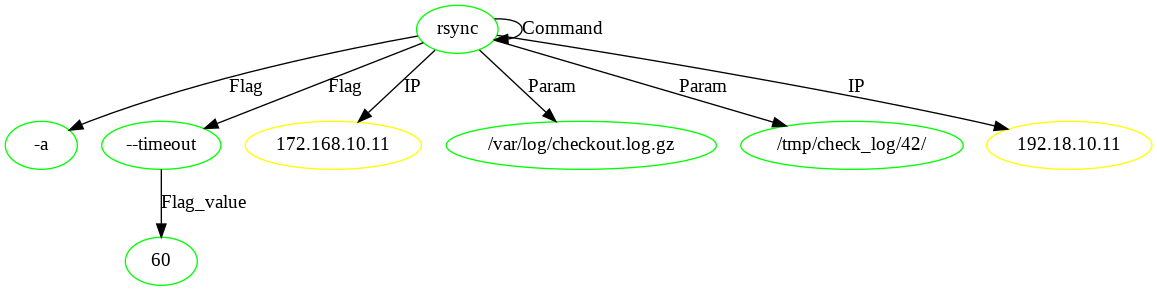

In [ ]:
base_command = 'rsync -a --timeout=60 172.168.10.11: /var/log/checkout.log.gz /tmp/check_log/42/'
tokens1 = ['Command', 'Flag', 'Flag', 'Flag_value', 'IP', 'Param', 'Param']
nodes1= ['rsync',  '-a',  '--timeout',  '60',  '172.168.10.11',  '/var/log/checkout.log.gz',  '/tmp/check_log/42/']

new_command = 'rsync -a --timeout=60 192.18.10.11 /var/log/checkout.log.gz /tmp/check_log/42/'
tokens2 = ['Command', 'Flag', 'Flag', 'Flag_value', 'IP', 'Param', 'Param']
nodes2 = ['rsync',  '-a',  '--timeout',  '60',  '192.18.10.11', '/var/log/checkout.log.gz',  '/tmp/check_log/42/']


compare_graphs(tokens1, nodes1, tokens2, nodes2)

            Flag_value   IP  Param  Flag  Command
Flag_value         1.0  0.0    0.0   0.0      0.0
Flag               0.0  0.0    0.0   2.0      0.0
Command            0.0  0.0    0.0   0.0      1.0
Param              0.0  0.0    2.0   0.0      0.0
Similarity Score of the given commands is:  0.75


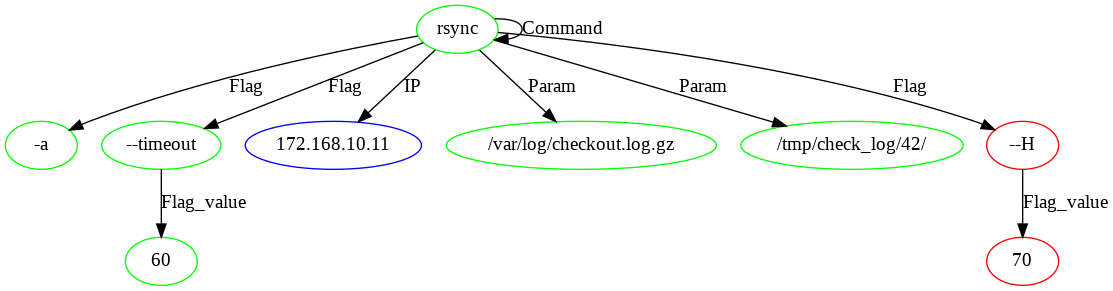

In [ ]:
base_command = 'rsync -a --timeout=60 172.168.10.11: /var/log/checkout.log.gz /tmp/check_log/42/'
tokens1 = ['Command', 'Flag', 'Flag', 'Flag_value', 'IP', 'Param', 'Param']
nodes1= ['rsync',  '-a',  '--timeout',  '60',  '172.168.10.11',  '/var/log/checkout.log.gz',  '/tmp/check_log/42/']

new_command = 'rsync -a --timeout=60  --H=70 /var/log/checkout.log.gz /tmp/check_log/42/'
tokens2 = ['Command', 'Flag', 'Flag', 'Flag_value',  'Flag','Flag_value', 'Param', 'Param']
nodes2 = ['rsync',  '-a',  '--timeout',  '60',   '--H','70',  '/var/log/checkout.log.gz',  '/tmp/check_log/42/']

compare_graphs(tokens1, nodes1, tokens2, nodes2)


            Flag_value   IP  Param  Flag  Command
Flag_value         1.0  0.0    0.0   0.0      0.0
Flag               0.0  0.0    0.0   4.0      0.0
Command            0.0  0.0    0.0   0.0      0.8
Param              0.0  0.0    4.0   0.0      0.0
Similarity Score of the given commands is:  0.817


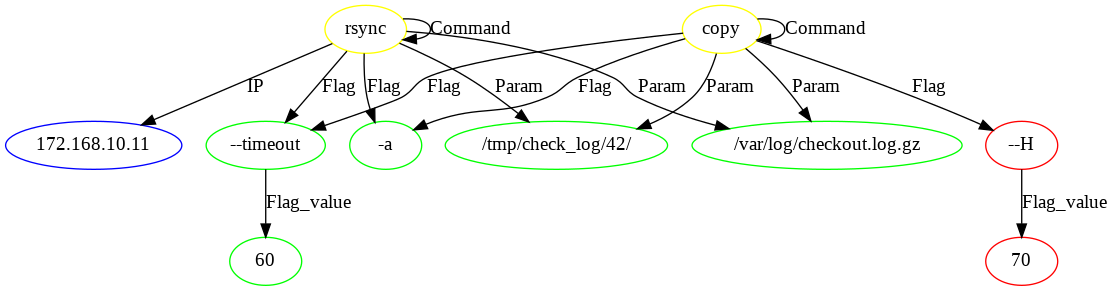

In [ ]:
base_command = 'rsync -a --timeout=60 172.168.10.11: /var/log/checkout.log.gz /tmp/check_log/42/'
tokens1 = ['Command', 'Flag', 'Flag', 'Flag_value', 'IP', 'Param', 'Param']
nodes1= ['rsync',  '-a',  '--timeout',  '60',  '172.168.10.11',  '/var/log/checkout.log.gz',  '/tmp/check_log/42/']

new_command = 'copy -a --timeout=60  --H=70 /var/log/checkout.log.gz /tmp/check_log/42/'
tokens2 = ['Command', 'Flag', 'Flag', 'Flag_value',  'Flag','Flag_value', 'Param', 'Param']
nodes2 = ['copy',  '-a',  '--timeout',  '60',   '--H','70',  '/var/log/checkout.log.gz',  '/tmp/check_log/42/']

compare_graphs(tokens1, nodes1, tokens2, nodes2)